# Import necessary libraries

In [ ]:
import os
import glob
import torch
import cv2
import random
from tqdm import tqdm
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
torch.manual_seed(42)

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


**Number of images and number of mask**

In [ ]:
mask_paths = glob.glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
image_paths = [i.replace('_mask', '') for i in mask_paths]
print(f'{len(mask_paths)} {len(image_paths)}')

3929 3929


**Plot function**

In [ ]:
def plot_from_img_path(n_examples, list_img_paths, list_mask_paths):

    fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)
    i = 0
    for ax in axs:
        image, mask = list_img_paths[i], list_mask_paths[i]
        image, mask = cv2.imread(image), cv2.imread(mask)
        ax[0].set_title("MRI images")
        ax[0].imshow(image)
        ax[1].set_title("Highlited abnormality")
        ax[1].imshow(image)
        ax[1].imshow(mask, alpha=0.2)
        ax[2].imshow(mask)
        ax[2].set_title("Abnormality mask")
        i += 1


# Visualizing images and masks

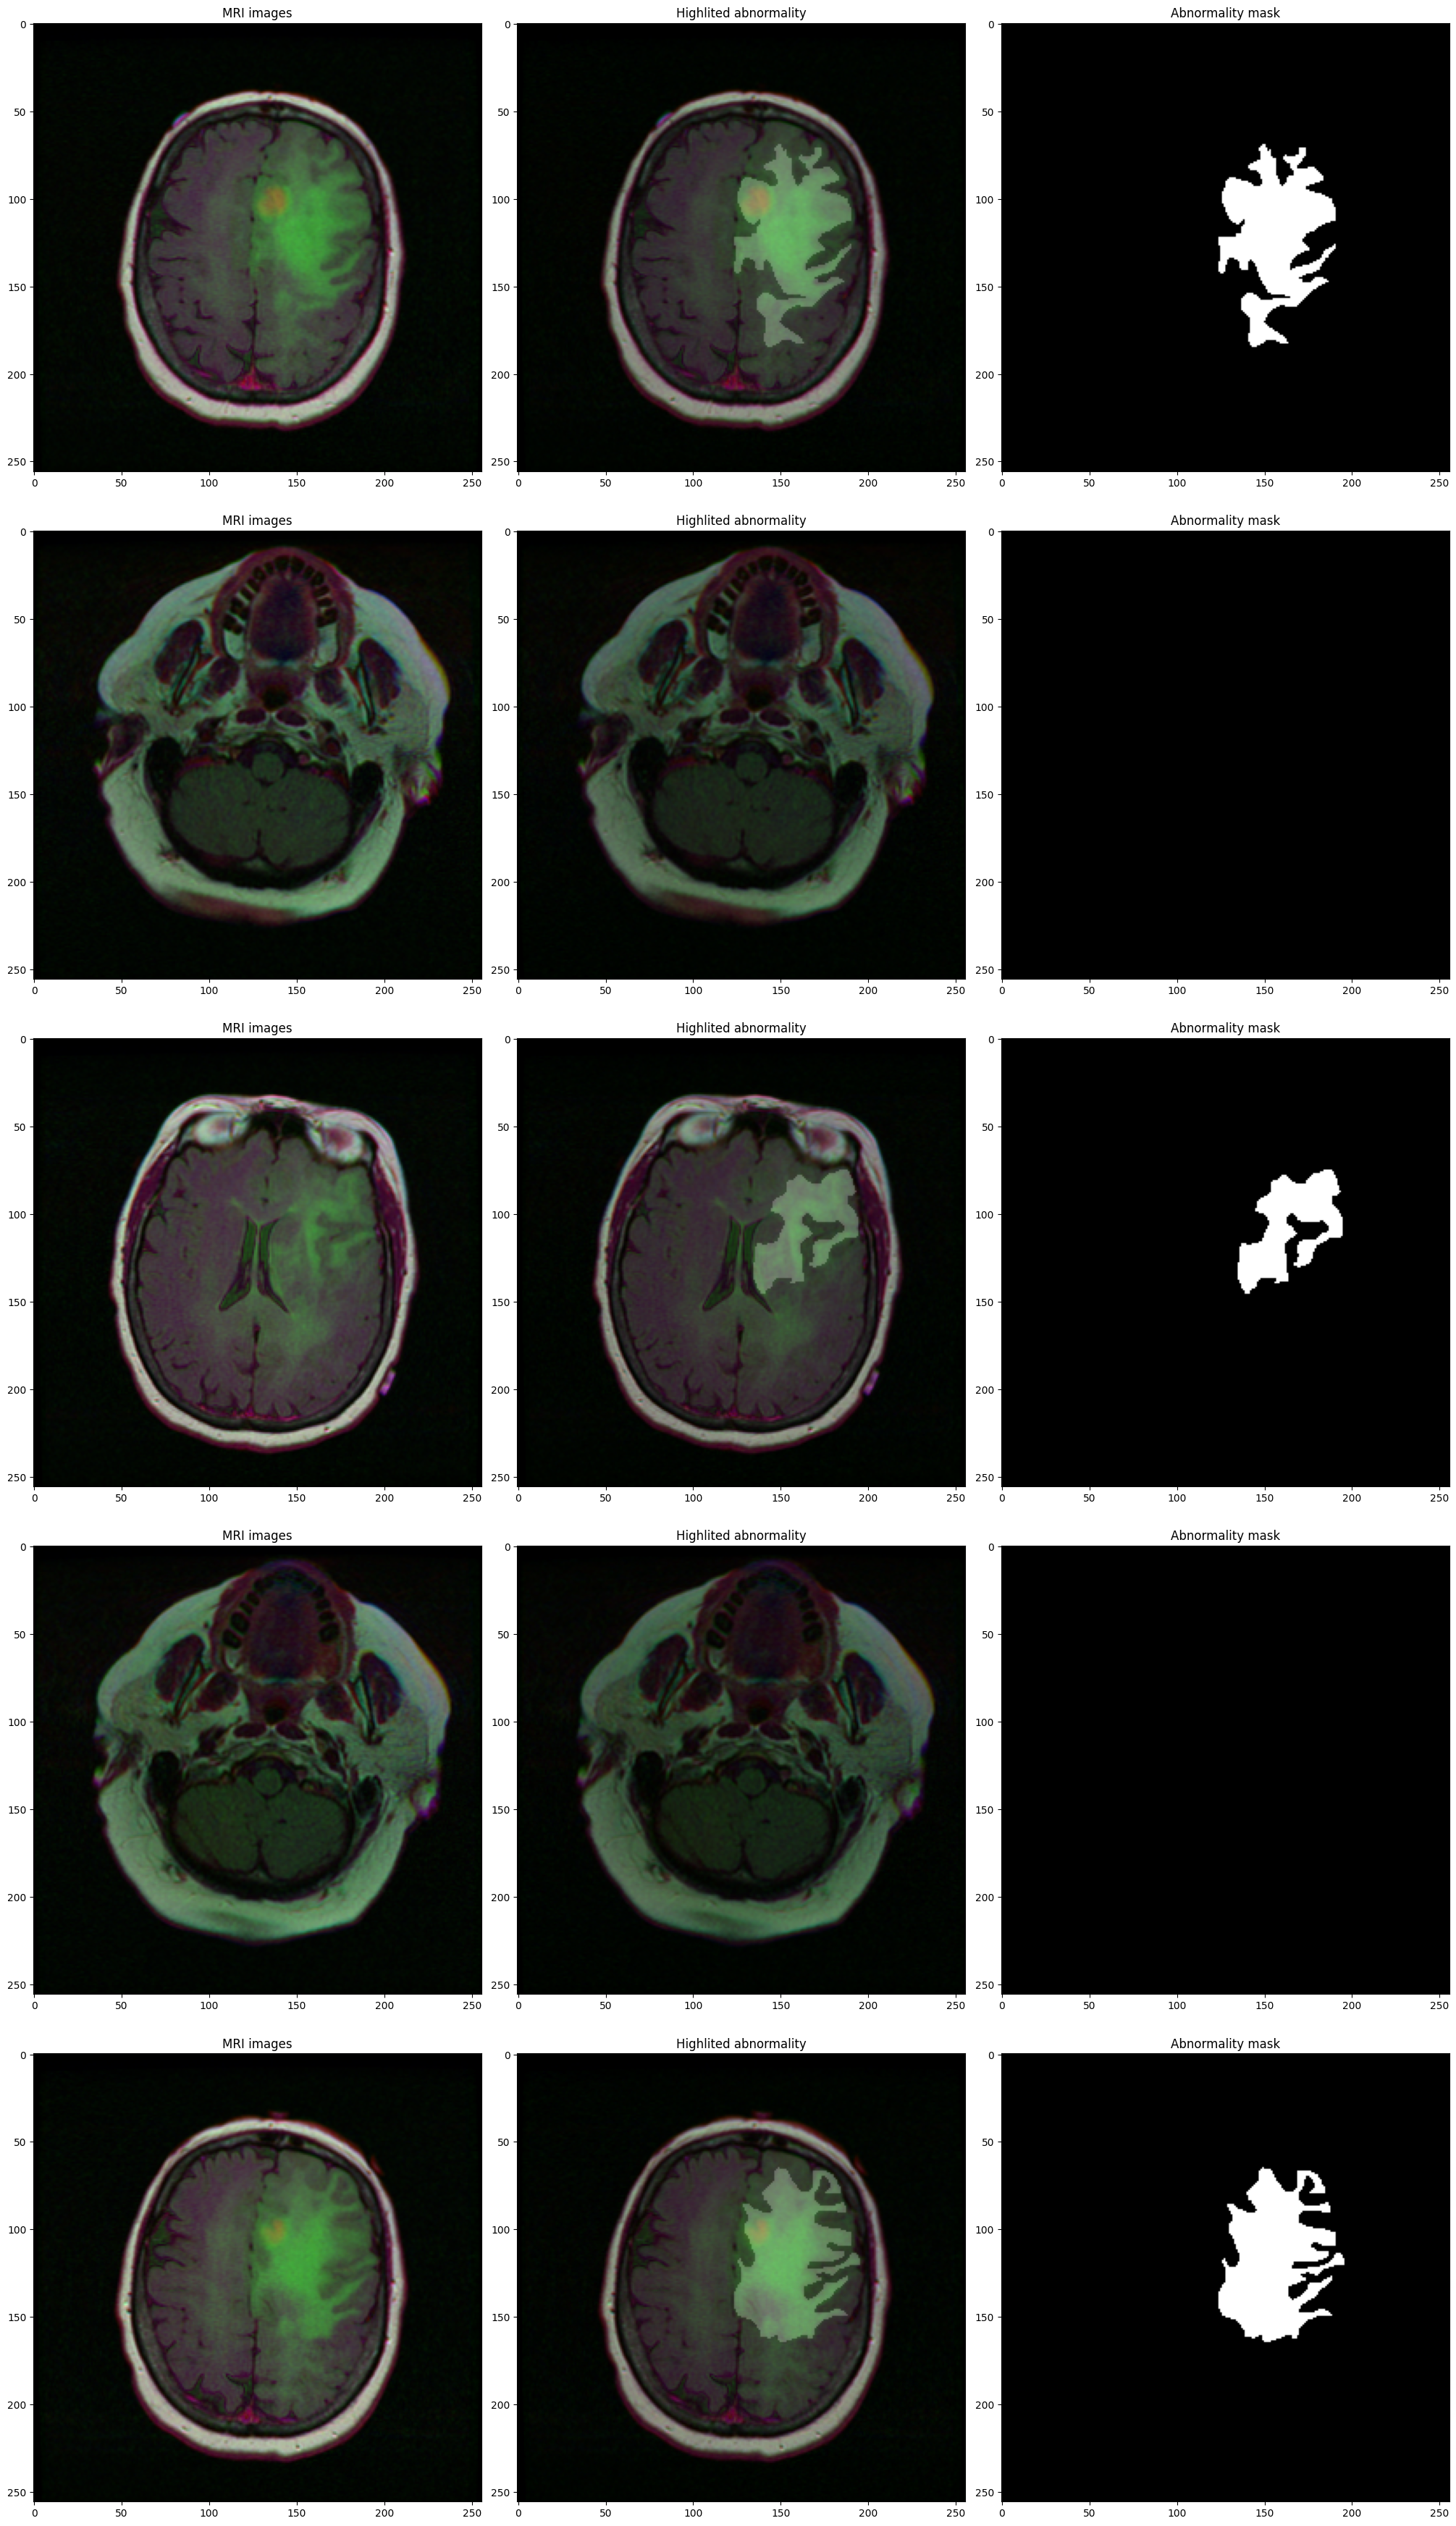

In [ ]:
plot_from_img_path(n_examples=5, list_img_paths=image_paths[5:], list_mask_paths=mask_paths[5:])

# Create dataframe and split dataset into train, val and test sets

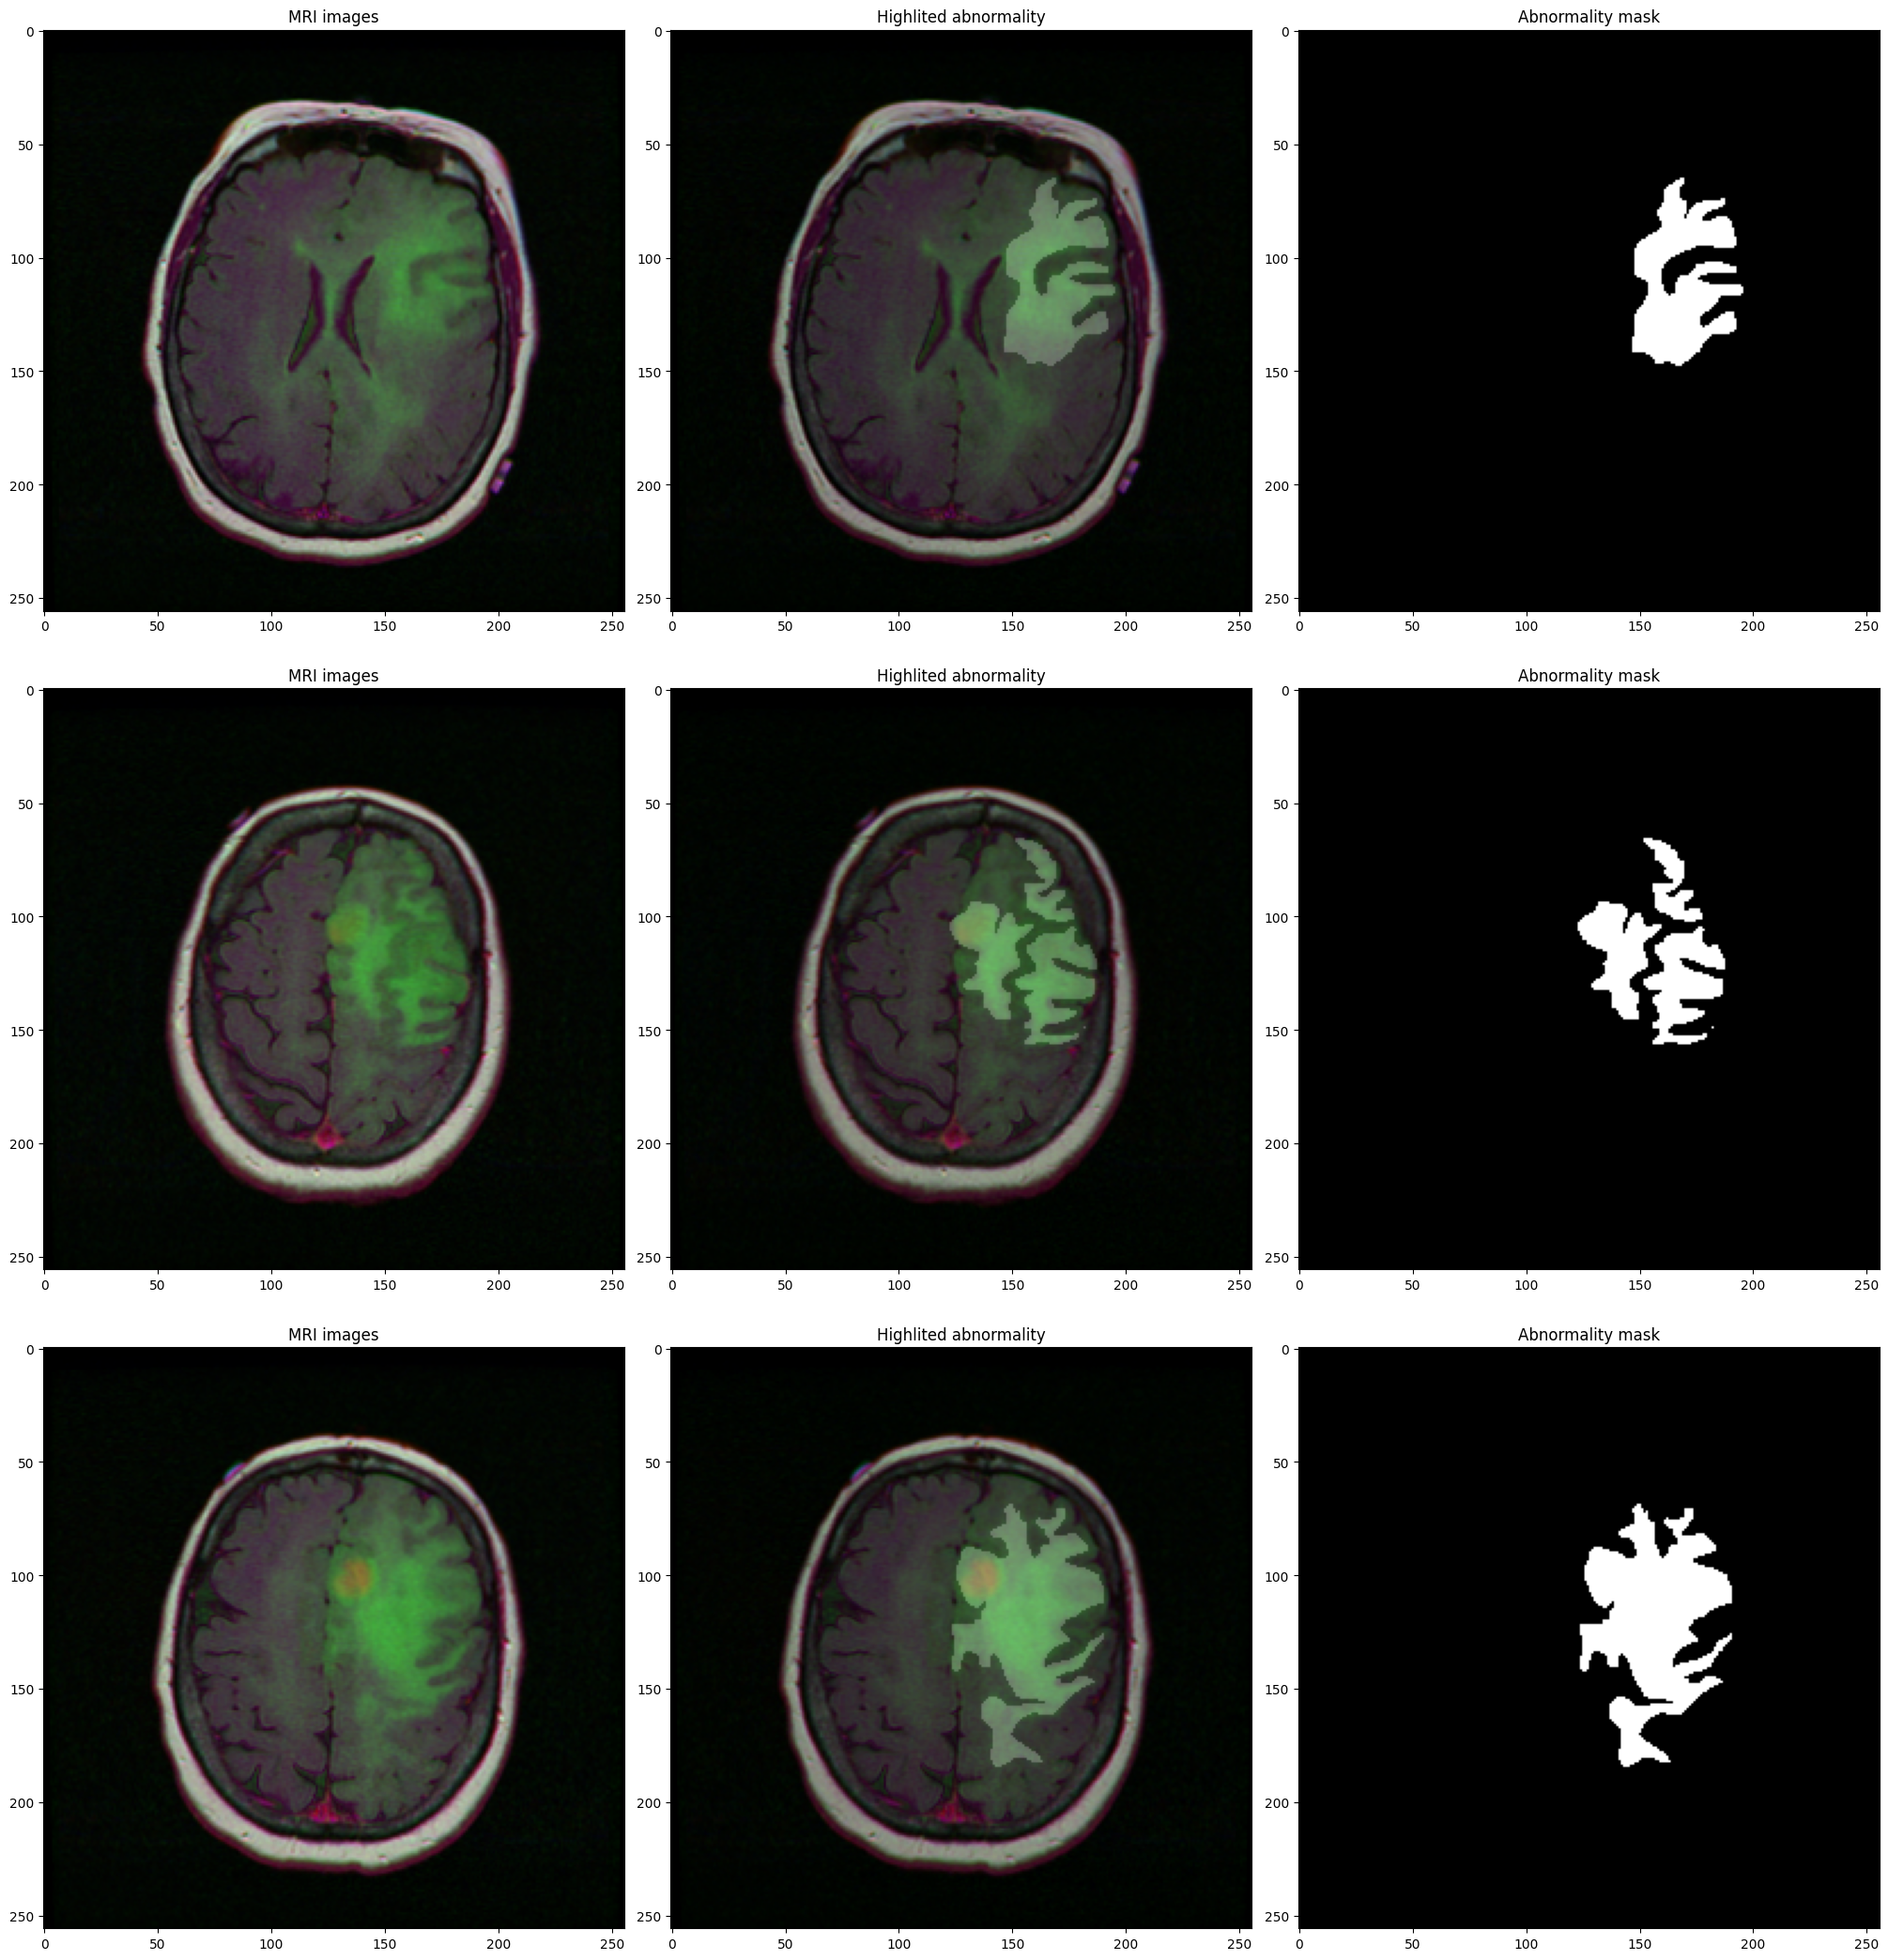

In [ ]:
df = pd.DataFrame(data={'image': image_paths, 'mask': mask_paths})
df.head()
plot_from_img_path(n_examples=3, list_img_paths=df.iloc[[3,4,5],0].tolist(), list_mask_paths=df.iloc[[3,4,5],1].tolist())

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
df_test, df_val = train_test_split(df_test, test_size=0.3, random_state=42)

print('train')
print(f"{df_train.describe().loc['count', ['image', 'mask']]}\n")
print('val')
print(f"{df_val.describe().loc['count', ['image', 'mask']]}\n")
print('test')
print(f"{df_test.describe().loc['count', ['image', 'mask']]}\n")

train
image    2750
mask     2750
Name: count, dtype: object

val
image    354
mask     354
Name: count, dtype: object

test
image    825
mask     825
Name: count, dtype: object



**MRI_Dataset is used for loading and preprocessing MRI images and their corresponding masks for medical image segmentation.**

In [ ]:
class MRI_Dataset(Dataset):
    def __init__(self, df, img_transform=None, mask_transform=None):
        self.image_paths = df['image']
        self.mask_paths = df['mask']
        self.img_transform = img_transform
        self.mask_transform = mask_transform
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_file = self.image_paths.iloc[idx]
        mask_file = self.mask_paths.iloc[idx]

        img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

        if self.img_transform:
            img = self.img_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return img, mask

**The Torchvision v2's Compose function, one for MRI images (train_img_transform) and one for segmentation masks (train_mask_transform). These transformations are applied to images and masks in the MRI_Dataset class before they are used for training.This transformation ensures the MRI images are in the correct format (torch.Tensor, float32, normalized) for input to a deep learning model.**

In [ ]:
train_img_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])
train_mask_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
val_img_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])
val_mask_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])

In [ ]:
test_img_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])
test_mask_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])

**This section creates datasets for training, validation, and testing by instantiating the MRI_Dataset class with different subsets of data (df_train, df_val, df_test).**

In [ ]:
train_dataset = MRI_Dataset(df_train, img_transform=train_img_transform, mask_transform=train_mask_transform)
val_dataset = MRI_Dataset(df_val, img_transform=val_img_transform, mask_transform=val_mask_transform)
test_dataset = MRI_Dataset(df_test, img_transform=test_img_transform, mask_transform=test_mask_transform)

**Creates PyTorch DataLoader instances for training, validation, and testing, ensuring efficient data loading in batches of 16. The train_dataloader shuffles data to improve model generalization, while val_dataloader and test_dataloader process validation and test datasets, respectively.**

In [ ]:
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

**Shows the image shape and the mask shape.**

In [ ]:
for img, mask in train_dataloader:
    print(img.shape)
    print(mask.shape)
    break

torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])


# Building the U-Net model
*Both the image and mask have the same image size (256 x 256). Fist the attention block is created for the network.*
The block applies 1x1 convolutions (W_g, W_x) followed by batch normalization to reduce dimensionality. The transformed signals are summed, passed through a ReLU activation, and then processed by psi, which applies another 1x1 convolution, batch normalization, and a sigmoid activation to generate an attention map. This attention map is multiplied with x, allowing the network to focus on important features while suppressing irrelevant ones.



![](https://th.bing.com/th/id/OIP._CbfZTbwAu1xx56rXdMPbAHaEy?w=287&h=186&c=7&r=0&o=5&dpr=1.3&pid=1.7)

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

**U-Net architecture with attention mechanisms to improve segmentation accuracy by focusing on important spatial features. It consists of an encoder, a bottleneck, and a decoder. The encoder extracts hierarchical features through convolutional blocks (_block) and max pooling layers. The bottleneck processes the deepest feature representations. The decoder upsamples the features using transpose convolutions, applies attention blocks (AttentionBlock) to selectively enhance relevant encoder features, and concatenates them before passing through convolutional layers. Finally, a 1x1 convolution with a sigmoid activation generates the segmentation output. The _block method defines a double convolutional layer with batch normalization and ReLU activation, forming the core building block of the network.**

In [ ]:
class UNetWithAttention(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNetWithAttention, self).__init__()

        features = init_features
        self.encoder1 = UNetWithAttention._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNetWithAttention._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNetWithAttention._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNetWithAttention._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNetWithAttention._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNetWithAttention._block((features * 8) * 2, features * 8, name="dec4")
        self.att4 = AttentionBlock(F_g=features * 8, F_l=features * 8, F_int=features * 4)

        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNetWithAttention._block((features * 4) * 2, features * 4, name="dec3")
        self.att3 = AttentionBlock(F_g=features * 4, F_l=features * 4, F_int=features * 2)

        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNetWithAttention._block((features * 2) * 2, features * 2, name="dec2")
        self.att2 = AttentionBlock(F_g=features * 2, F_l=features * 2, F_int=features)

        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNetWithAttention._block(features * 2, features, name="dec1")
        self.att1 = AttentionBlock(F_g=features, F_l=features, F_int=features // 2)

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        att4 = self.att4(dec4, enc4)
        dec4 = torch.cat((att4, dec4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        att3 = self.att3(dec3, enc3)
        dec3 = torch.cat((att3, dec3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        att2 = self.att2(dec2, enc2)
        dec2 = torch.cat((att2, dec2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        att1 = self.att1(dec1, enc1)
        dec1 = torch.cat((att1, dec1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )

**The UNetWithAttention instance is created with 3 input channels (e.g., RGB images), 1 output channel (e.g., a binary segmentation mask), and 32 initial feature maps. The model is then moved to the specified computing device (device), which could be a GPU (cuda) or CPU (cpu), ensuring efficient computation. Finally, print(model) displays the model's architecture, including all layers, helping to verify its structure before training.**

In [ ]:
model = UNetWithAttention(in_channels=3, out_channels=1, init_features=32)
model = model.to(device)
print(model)

UNetWithAttention(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d

# Initialize the loss function and optimizer with learning rate 0.001

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop

In [ ]:
def training_loop(epochs, model, train_dataloader, val_dataloader,
                  loss_fn, optimizer):
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss = 0
        for data in tqdm(train_dataloader):
            img, mask = data
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            loss = loss_fn(pred, mask)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            running_val_loss = 0
            for data in tqdm(val_dataloader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                pred = model(img)
                loss = loss_fn(pred, mask)
                running_val_loss += loss.item()

        train_loss = running_train_loss / len(train_dataloader.dataset)
        val_loss = running_val_loss / len(val_dataloader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss} | Validation loss: {val_loss}')

    model.eval()
    return history

In [ ]:
epochs = 30
history = training_loop(epochs, model, train_dataloader, val_dataloader,
                        criterion, optimizer)

100%|██████████| 23/23 [00:08<00:00,  2.85it/s]


Epoch: 1/30 | Training loss: 0.012228149983015928 | Validation loss: 0.005357121427853902


100%|██████████| 23/23 [00:02<00:00,  9.36it/s]


Epoch: 2/30 | Training loss: 0.003065922187133269 | Validation loss: 0.0025034508231164374


100%|██████████| 23/23 [00:02<00:00,  9.43it/s]


Epoch: 3/30 | Training loss: 0.0018228658420795744 | Validation loss: 0.0017992343101124306


100%|██████████| 23/23 [00:02<00:00,  9.59it/s]


Epoch: 4/30 | Training loss: 0.001431400221518495 | Validation loss: 0.002009100136005104


100%|██████████| 23/23 [00:02<00:00,  9.70it/s]


Epoch: 5/30 | Training loss: 0.0011841368087652055 | Validation loss: 0.0013649265892214358


100%|██████████| 23/23 [00:02<00:00,  9.19it/s]


Epoch: 6/30 | Training loss: 0.0010749997374686327 | Validation loss: 0.0013096148363909142


100%|██████████| 23/23 [00:02<00:00,  9.24it/s]


Epoch: 7/30 | Training loss: 0.0009912241106344894 | Validation loss: 0.0012946208244410612


100%|██████████| 23/23 [00:02<00:00,  9.37it/s]


Epoch: 8/30 | Training loss: 0.0009458070793612437 | Validation loss: 0.0009604927200408348


100%|██████████| 23/23 [00:02<00:00,  9.55it/s]


Epoch: 9/30 | Training loss: 0.0009084950939498164 | Validation loss: 0.0009161165440560314


100%|██████████| 23/23 [00:02<00:00,  9.72it/s]


Epoch: 10/30 | Training loss: 0.0008186683639545332 | Validation loss: 0.000934475008135209


100%|██████████| 23/23 [00:02<00:00,  9.34it/s]


Epoch: 11/30 | Training loss: 0.0007846324347298253 | Validation loss: 0.0009981453554220709


100%|██████████| 23/23 [00:02<00:00,  9.60it/s]


Epoch: 12/30 | Training loss: 0.0007529016511345452 | Validation loss: 0.0030764152353766274


100%|██████████| 23/23 [00:02<00:00,  9.28it/s]


Epoch: 13/30 | Training loss: 0.0007756020125340332 | Validation loss: 0.0010622952654326366


100%|██████████| 23/23 [00:02<00:00,  9.58it/s]


Epoch: 14/30 | Training loss: 0.0006288767860017039 | Validation loss: 0.000701787811177809


100%|██████████| 23/23 [00:02<00:00,  9.37it/s]


Epoch: 15/30 | Training loss: 0.0006449391570958224 | Validation loss: 0.0007461325454888707


100%|██████████| 23/23 [00:02<00:00,  9.58it/s]


Epoch: 16/30 | Training loss: 0.0006181162737140601 | Validation loss: 0.0007162244548484431


100%|██████████| 23/23 [00:02<00:00,  9.60it/s]


Epoch: 17/30 | Training loss: 0.000532139133492654 | Validation loss: 0.0006933286286217008


100%|██████████| 23/23 [00:02<00:00,  9.60it/s]


Epoch: 18/30 | Training loss: 0.0005408312187276103 | Validation loss: 0.0009463830459021074


100%|██████████| 23/23 [00:02<00:00,  9.56it/s]


Epoch: 19/30 | Training loss: 0.0005365592825057155 | Validation loss: 0.0006114399857427084


100%|██████████| 23/23 [00:02<00:00,  9.65it/s]


Epoch: 20/30 | Training loss: 0.0005040026361715388 | Validation loss: 0.0009418534204405916


100%|██████████| 23/23 [00:02<00:00,  9.81it/s]


Epoch: 21/30 | Training loss: 0.00047575614279644056 | Validation loss: 0.0006190847544957184


100%|██████████| 23/23 [00:02<00:00,  9.61it/s]


Epoch: 22/30 | Training loss: 0.000429373496000401 | Validation loss: 0.0006349860793055236


100%|██████████| 23/23 [00:02<00:00,  9.56it/s]


Epoch: 23/30 | Training loss: 0.0004131299469789321 | Validation loss: 0.0005340308469868499


100%|██████████| 23/23 [00:02<00:00,  9.35it/s]


Epoch: 24/30 | Training loss: 0.0004276436003009704 | Validation loss: 0.000649126885704812


100%|██████████| 23/23 [00:02<00:00,  9.63it/s]


Epoch: 25/30 | Training loss: 0.0004248968874400651 | Validation loss: 0.0006429753384663392


100%|██████████| 23/23 [00:02<00:00,  9.43it/s]


Epoch: 26/30 | Training loss: 0.00039498148117722435 | Validation loss: 0.0004921116335314204


100%|██████████| 23/23 [00:02<00:00,  9.54it/s]


Epoch: 27/30 | Training loss: 0.0004387098713354631 | Validation loss: 0.000767382680001737


100%|██████████| 23/23 [00:02<00:00,  9.39it/s]


Epoch: 28/30 | Training loss: 0.0003968419604193927 | Validation loss: 0.0004771442994762128


100%|██████████| 23/23 [00:02<00:00,  9.85it/s]


Epoch: 29/30 | Training loss: 0.00035582582169974393 | Validation loss: 0.0006565729999325454


100%|██████████| 23/23 [00:02<00:00, 10.02it/s]

Epoch: 30/30 | Training loss: 0.000362545882478695 | Validation loss: 0.0004932973688431505


## Plot results

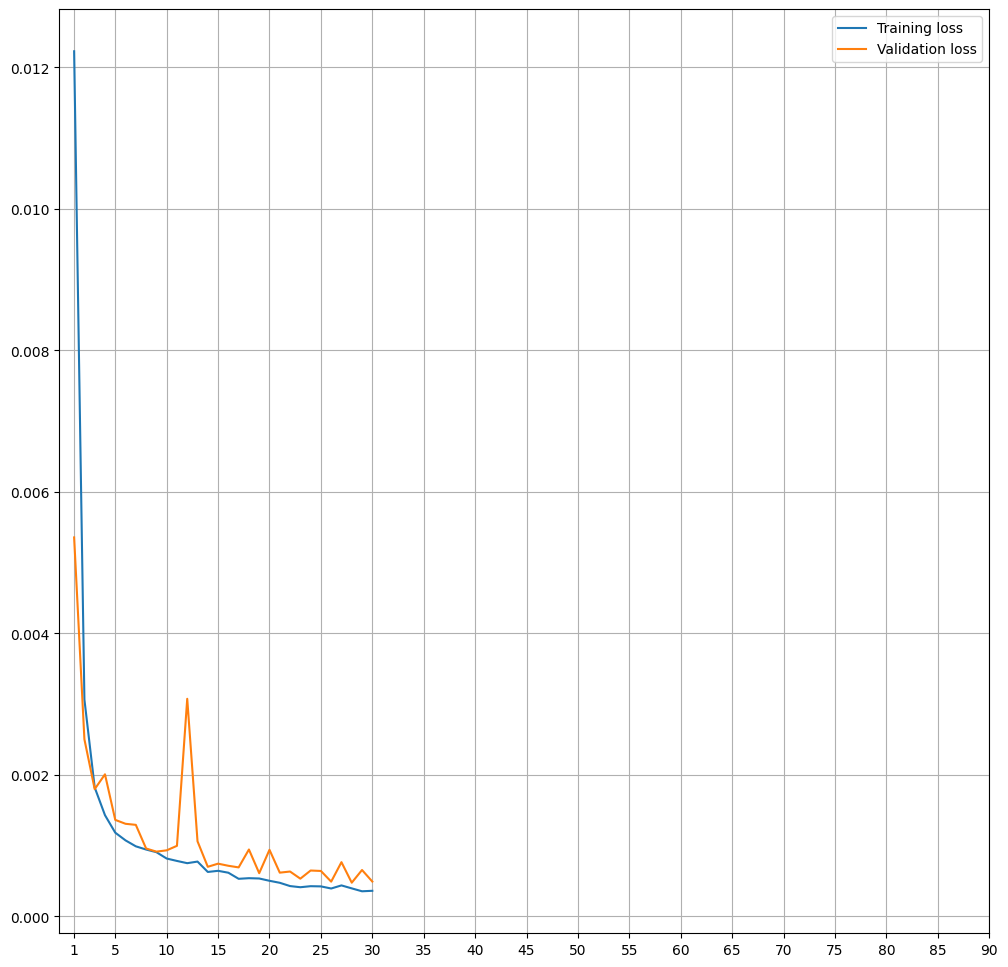

In [ ]:
plt.figure(figsize=(12, 12))
plt.plot(np.arange(1,epochs+1), history['train_loss'], label='Training loss')
plt.plot(np.arange(1,epochs+1), history['val_loss'], label='Validation loss')
plt.xticks([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90])
plt.grid()
plt.legend()
plt.show()

# Test set evaluation function

In [ ]:
def test_set_evaluation(models):
    for key, model in models.items():
        with torch.no_grad():
            running_loss = 0
            for i, data in enumerate(test_dataloader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                loss = criterion(predictions, mask)
                running_loss += loss.item() * img.size(0)
            loss = running_loss / len(test_dataset)

            print(f'Test loss with {key}: {loss}')

# Training loss of the model

In [ ]:
test_set_evaluation({"current_model": model})

Test loss with current_model: 0.008107049815130956


# Visualize the test result

In [ ]:
def visualize_segmentation(model, dataloader, num_examples=1):
    model.eval()

    # Get all indices of the dataset and randomly sample 'num_examples' indices
    dataset_size = len(dataloader.dataset)
    random_indices = random.sample(range(dataset_size), num_examples)

    for idx in random_indices:
        img, mask = dataloader.dataset[idx]  # Access the dataset by index
        img, mask = img.to(device).unsqueeze(0), mask.to(device).unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            pred = model(img)

        # Squeeze to remove batch and channel dimensions
        img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert to HWC format for display
        mask = mask.squeeze(0).squeeze(0).cpu().numpy()
        pred = pred.squeeze(0).squeeze(0).cpu().numpy()
        binary_pred = pred > 0.5

        # Plot
        fig, axes = plt.subplots(1, 4, figsize=(12, 4))
        axes[0].imshow(img, cmap='gray' if img.shape[-1] == 1 else None)
        axes[0].set_title('Input Image')
        axes[0].axis('off')

        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('True Mask')
        axes[1].axis('off')

        axes[2].imshow(pred, cmap='gray')
        axes[2].set_title('Predicted Mask')
        axes[2].axis('off')

        axes[3].imshow(binary_pred, cmap='gray')
        axes[3].set_title('Binary Predicted Mask')
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()


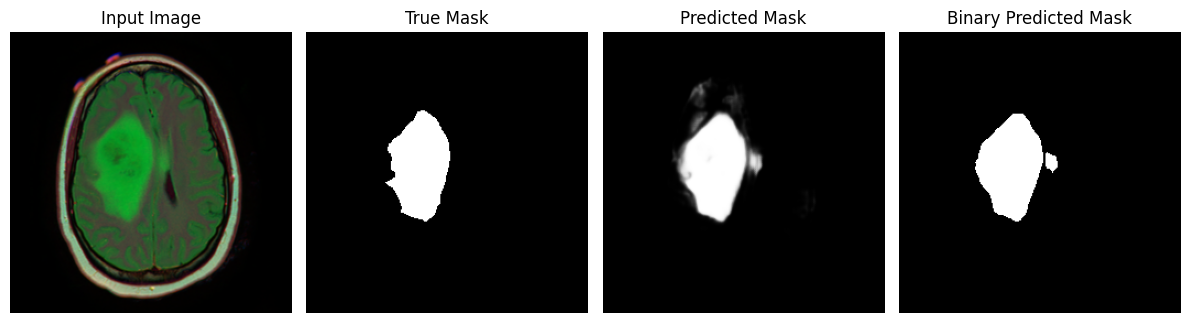

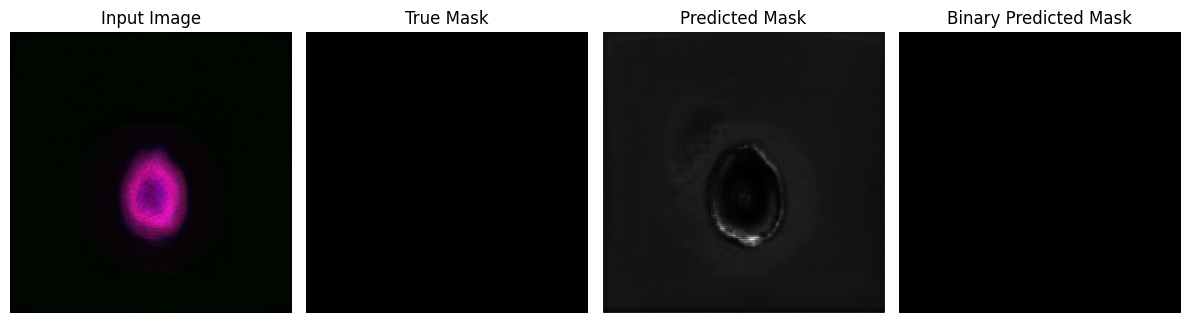

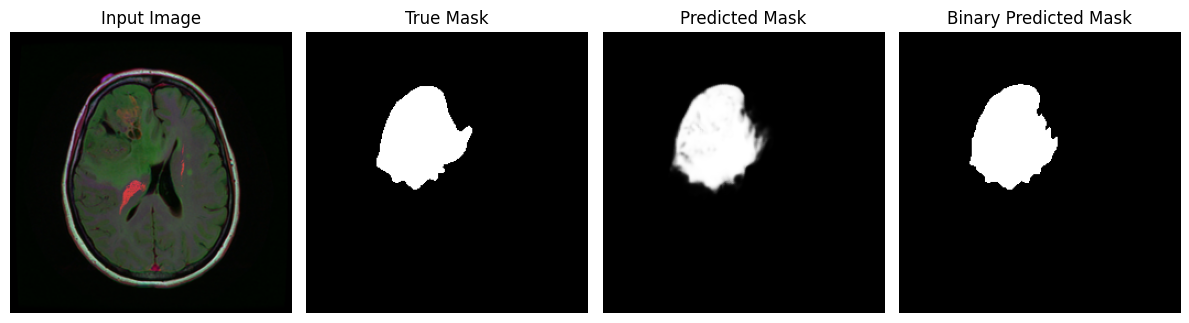

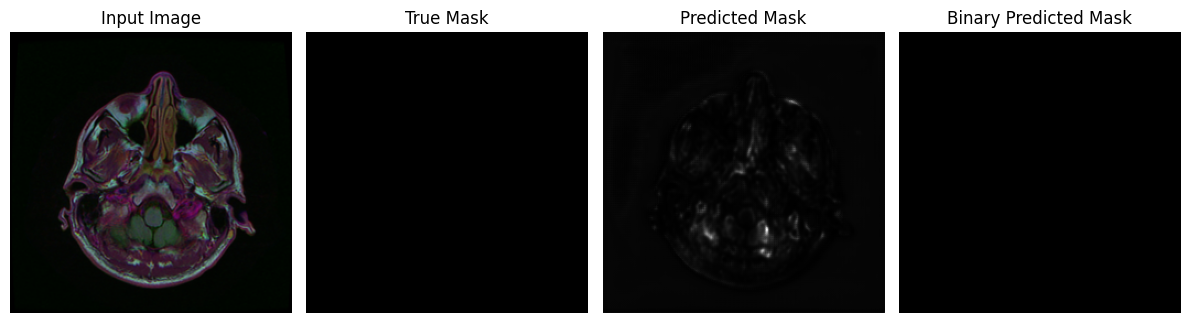

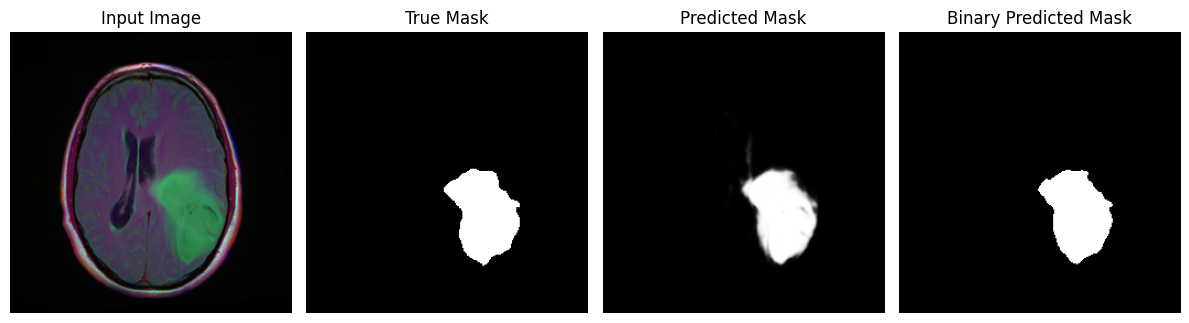

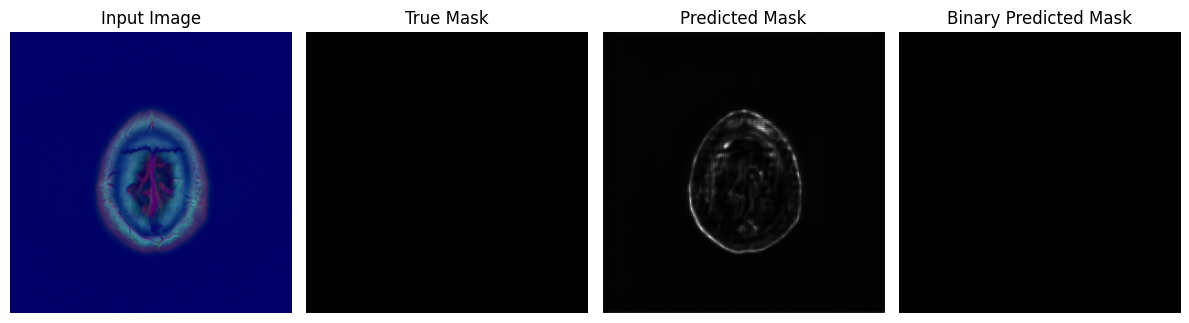

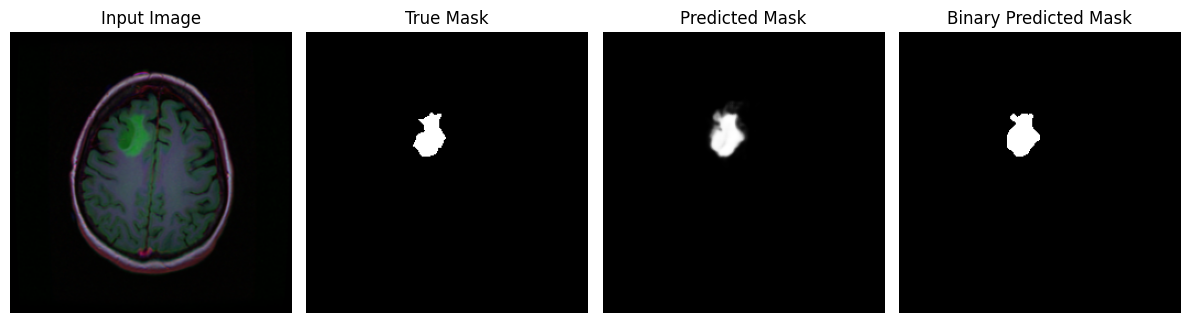

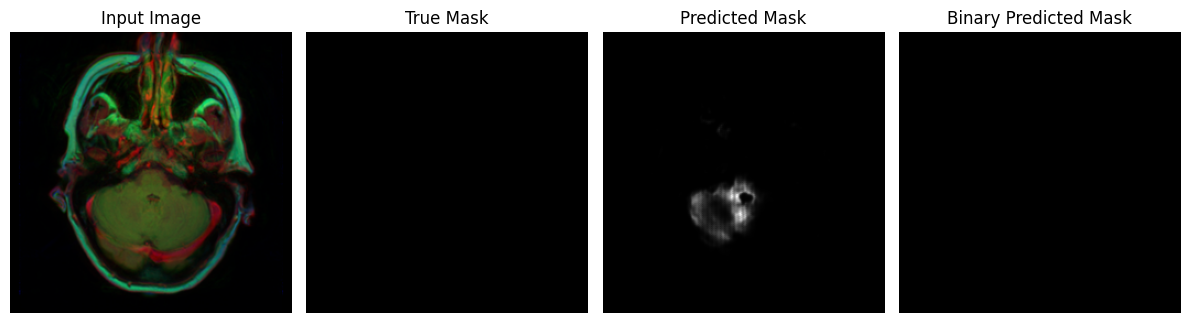

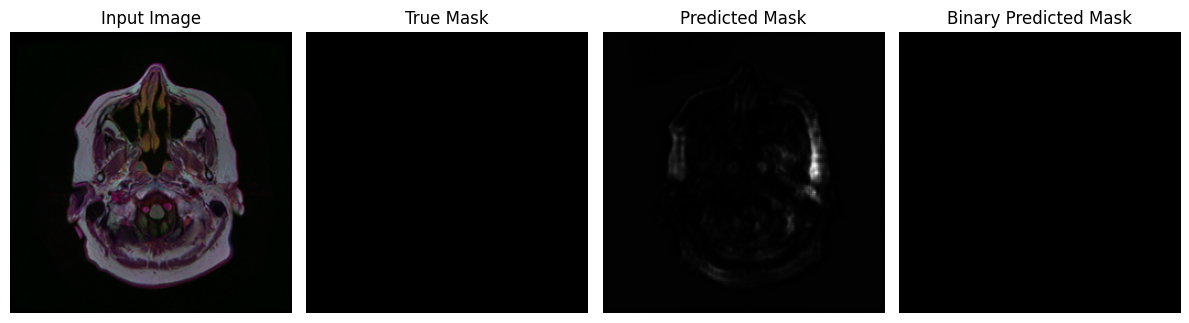

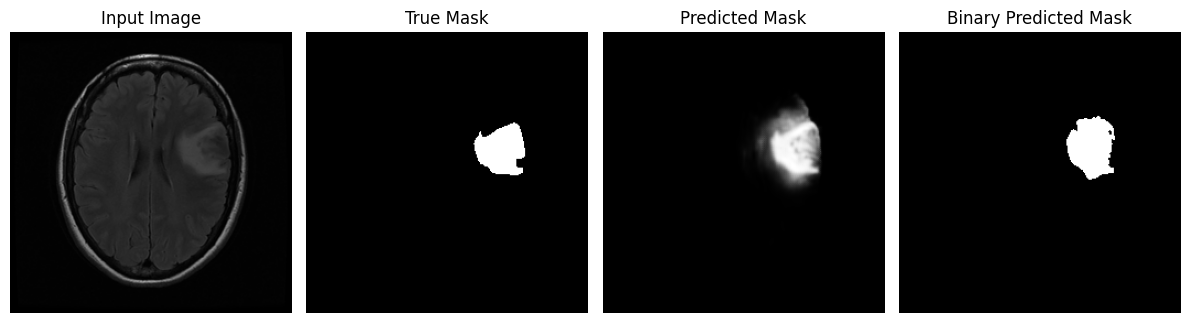

In [ ]:
visualize_segmentation(model, test_dataloader, 10)